In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import RobustScaler

import warnings
warnings.filterwarnings('ignore')

plt.style.use('seaborn-whitegrid')

In [2]:
df = pd.read_csv('df_final.csv')
print('Le DataFrame contient', df.shape[0], 'lignes qui sont nos clients, et',
      df.shape[1], 'colonnes (dont l\'ID du client et sa target)')
df.head()

Le DataFrame contient 252133 lignes qui sont nos clients, et 517 colonnes (dont l'ID du client et sa target)


,SK_ID_CURR,TARGET,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,...,INSTAL_AMT_INSTALMENT_MEAN,INSTAL_AMT_INSTALMENT_SUM,INSTAL_AMT_PAYMENT_MIN,INSTAL_AMT_PAYMENT_MAX,INSTAL_AMT_PAYMENT_MEAN,INSTAL_AMT_PAYMENT_SUM,INSTAL_DAYS_ENTRY_PAYMENT_MAX,INSTAL_DAYS_ENTRY_PAYMENT_MEAN,INSTAL_DAYS_ENTRY_PAYMENT_SUM,INSTAL_COUNT
0,100002,1,0,0,0,0,202500.0,406597.5,24700.5,351000.0,...,11559.247105,219625.695,9251.775,53093.745,11559.247105,219625.695,-49.0,-315.421053,-5993.0,19.0
1,100003,0,1,0,1,0,270000.0,1293502.5,35698.5,1129500.0,...,64754.586000,1618864.650,6662.970,560835.360,64754.586000,1618864.650,-544.0,-1385.320000,-34633.0,25.0
2,100004,0,0,1,0,0,67500.0,135000.0,6750.0,135000.0,...,7096.155000,21288.465,5357.250,10573.965,7096.155000,21288.465,-727.0,-761.666667,-2285.0,3.0
3,100006,0,1,0,0,0,135000.0,312682.5,29686.5,297000.0,...,62947.088438,1007153.415,2482.920,691786.890,62947.088438,1007153.415,-12.0,-271.625000,-4346.0,16.0
4,100007,0,0,0,0,0,121500.0,513000.0,21865.5,513000.0,...,12666.444545,835985.340,0.180,22678.785,12214.060227,806127.975,-14.0,-1032.242424,-68128.0,66.0


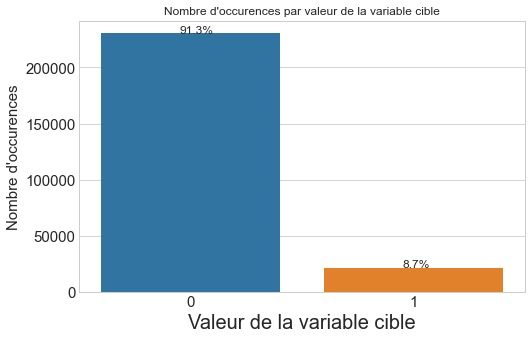

In [3]:
def without_hue(plot, feature):
    total = len(feature)
    for p in ax.patches:
        percentage = '{:.1f}%'.format(100 * p.get_height()/total)
        x = p.get_x() + p.get_width() / 2 - 0.05
        y = p.get_y() + p.get_height()
        ax.annotate(percentage, (x, y), size=12)
    plt.show()


fig = plt.figure(figsize=(8, 5))
ax = sns.barplot(x=df['TARGET'].value_counts().index,
                 y=df['TARGET'].value_counts().values)
plt.title('Nombre d\'occurences par valeur de la variable cible')
plt.xlabel('Valeur de la variable cible', fontsize=20)
plt.ylabel('Nombre d\'occurences', fontsize=15)
plt.tick_params(axis='both', which='major', labelsize=15)

without_hue(ax, df['TARGET'])

In [4]:
df['TARGET'].value_counts()

0    230298
1     21835
Name: TARGET, dtype: int64

La variable ```TARGET``` est notre variable cible. Elle vaut 1 lorsque le client a des difficultés de paiement (il a payé en retard d'au moins X jours au moins une fois dans les Y premiers remboursements du prêt) et 0 sinon.

## Préparation des données

### Séparation en sous-ensemble d'entraînement et de test

In [5]:
X = df.loc[:, df.columns != 'TARGET']
y = df['TARGET']
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42)

In [6]:
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(176493, 516)
(75640, 516)
(176493,)
(75640,)


### Traitement des valeurs manquantes

In [7]:
columns_int = list(X_train.select_dtypes(include=['uint8', 'int64']).columns)
columns_float = list(X_train.select_dtypes(include=['float64']).columns)

In [8]:
X_train_preprocess = X_train.copy()
X_test_preprocess = X_test.copy()

Application de SimpleImputer pour remplacer les Nan selon 2 stratégies:
- Si la variable est discrète, on remplace Nan par la valeur la plus fréquente pour cette variable.
- Si la variable est continue, on remplace Nan par la moyenne des valeurs pour cette variable.

In [9]:
imp_most_frequent = SimpleImputer(strategy="most_frequent")
imp_most_frequent.fit(X_train_preprocess[columns_int])
X_train_preprocess[columns_int] = imp_most_frequent.transform(X_train_preprocess[columns_int])
X_test_preprocess[columns_int] = imp_most_frequent.transform(X_test_preprocess[columns_int])

imp_mean = SimpleImputer(strategy="mean")
imp_mean.fit(X_train_preprocess[columns_float])
X_train_preprocess[columns_float] = imp_mean.transform(X_train_preprocess[columns_float])
X_test_preprocess[columns_float] = imp_mean.transform(X_test_preprocess[columns_float])

### Normalisation

In [11]:
std_scale_X = RobustScaler().fit(X_train_preprocess[columns_float])
X_train_preprocess[columns_float] = std_scale_X.transform(X_train_preprocess[columns_float])
X_test_preprocess[columns_float] = std_scale_X.transform(X_test_preprocess[columns_float])

## Modélisation

In [12]:
def RSE(y_test, predictions):
    y_barre = np.mean(y_test)
    RSE = sum((y_test - predictions)**2)/sum((y_test - y_barre)**2)
    return RSE


def Performances(y_test, predictions, seuil=0.5):
    scores = []

    # RMSE et MSE
    MSE = mean_squared_error(y_test, predictions, squared=True)
    print('RMSE = {:.2f}'.format(MSE**(1/2)))
    print('MSE = {:.2f}'.format(MSE))
    scores.append(MSE**(1/2))
    scores.append(MSE)

    # RSE
    RSE_ = RSE(y_test, predictions)
    print('RSE = {:.2f}'.format(RSE_))
    scores.append(RSE_)

    # ROC AUC score
    ROC_AUC = roc_auc_score(y_test, predictions)
    print('ROC_AUC = {:.2f}'.format(ROC_AUC))
    scores.append(ROC_AUC)

    # Courbe ROC
    [fpr, tpr, thr] = roc_curve(y_test, predictions)
    scores.append([fpr, tpr, thr])
    plt.plot(fpr, tpr, color='coral', lw=2, label='Classifier')
    plt.plot([0, 1], [0, 1], linestyle='--', label='No Skill')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.01])
    plt.xlabel('1 - Spécificité', fontsize=14)
    plt.ylabel('Sensibilité', fontsize=14)
    plt.show()

    y_pred = pd.Series(predictions).apply(lambda x: 1 if x >= seuil else 0)
    # Matrice de confusion
    #cmap = 'PuRd'
    #pp_matrix_from_data(y_test, y_pred)

    # Rappel et précision
    Recall = recall_score(y_test, y_pred)
    Precision = precision_score(y_test, y_pred)
    print('Recall = {:.2f}'.format(Recall))
    print('Precision = {:.2f}'.format(Precision))
    scores.append(Recall)
    scores.append(Precision)

    # F1-score
    F1 = f1_score(y_test, y_pred)
    print('Score F1 = {:.2f}'.format(F1))
    scores.append(F1)

    return scores

1. DummyClassifier
2. RandomForestClassifier
3. LGBM
4. XGBoost
5. Logistic Regression

### Dummy Classifier

In [ ]:
np.random.seed(5)
param_dummy = {'strategy':
               ['most_frequent', 'stratified', 'uniform', 'constant']}
cv_strat = StratifiedKFold(n_splits=10, shuffle=True, random_state=45)

dummy = GridSearchCV(DummyClassifier(random_state=0),
                     param_grid=param_dummy,
                     verbose=2,
                     scoring='roc_auc',
                     cv=cv_strat,
                     return_train_score=True,
                     n_jobs=-1)

dummy.fit(X_train, y_train)
prediction_dummy = dummy.predict_proba(X_test)

print('Meilleurs hyperparamètres : ' + str(dummy.best_params_))

fit_time_dummy = dummy.cv_results_['mean_fit_time'].mean()
pred_time_dummy = dummy.cv_results_['mean_score_time'].mean()
print('Temps écoulé pour l\'entraînement = {:.2f}s'.format(fit_time_dummy))
print('Temps écoulé pour la prédiction = {:.2f}s'.format(pred_time_dummy))

In [ ]:
perf_dummy = Performances(y_test, prediction_dummy[:, 1])

### Random Forest

In [ ]:
param_RF = {'n_estimators': [120, 140],
            'max_depth': [30, 50],
            'min_samples_split': [2, 3],
            'min_samples_leaf': [3, 5],
            'class_weight':
            [{0: 1, 1: 1}, {0: 1, 1: 5}, {0: 1, 1: 3}, 'balanced']
            }

RF = GridSearchCV(RandomForestClassifier(random_state=0),
                  param_grid=param_RF,
                  scoring='roc_auc',
                  verbose=2,
                  cv=cv_strat,
                  return_train_score=True,
                  n_jobs=-1)

RF.fit(X_train, y_train)
prediction_RF = RF.predict_proba(X_test)
print('Meilleurs hyperparamètres : ' + str(RF.best_params_))

fit_time_RF = RF.cv_results_['mean_fit_time'].mean()
pred_time_RF = RF.cv_results_['mean_score_time'].mean()
print('Temps écoulé pour l\'entraînement = {:.2f}s'.format(fit_time_RF))
print('Temps écoulé pour la prédiction = {:.2f}s'.format(pred_time_RF))

In [ ]:
perf_RF = Performances(y_test, prediction_RF[:, 1])

### LightGBM

In [ ]:
param_LGBM = {'max_depth': [5, 10, 15],
              'learning_rate': [0.1, 0.15, 0.3],
              'num_leaves': [32, 150, 200],
              'n_estimators': [300, 400],
              'class_weight':
              [{0: 1, 1: 1}, {0: 1, 1: 5}, {0: 1, 1: 3}, 'balanced']}

LGBM = GridSearchCV(LGBMClassifier(random_state=0),
                    param_grid=param_LGBM,
                    scoring='roc_auc',
                    verbose=2,
                    cv=cv_strat,
                    return_train_score=True,
                    n_jobs=-1)

LGBM.fit(X_train, y_train)
prediction_LGBM = LGBM.predict_proba(X_test)

print('Meilleurs hyperparamètres : ' + str(LGBM.best_params_))

fit_time_LGBM = LGBM.cv_results_['mean_fit_time'].mean()
pred_time_LGBM = LGBM.cv_results_['mean_score_time'].mean()
print('Temps écoulé pour l\'entraînement = {:.2f}s'.format(fit_time_LGBM))
print('Temps écoulé pour la prédiction = {:.2f}s'.format(pred_time_LGBM))

In [ ]:
perf_LGBM = Performances(y_test, prediction_LGBM[:, 1])

### XGBoost

In [ ]:
param_XGB = {'max_depth': range(2, 10, 1),
             'n_estimators': range(60, 220, 40),
             'learning_rate': [0.1, 0.01, 0.05],
             'scale_pos_weight':
             [{0: 1, 1: 1}, {0: 1, 1: 5}, {0: 1, 1: 3}, 'balanced']}

XGB = GridSearchCV(XGBClassifier(random_state=0),
                   param_grid=param_XGB,
                   scoring='roc_auc',
                   verbose=2,
                   cv=cv_strat,
                   return_train_score=True,
                   n_jobs=-1)

XGB.fit(X_train, y_train)
prediction_XGB = XGB.predict_proba(X_test)

print('Meilleurs hyperparamètres : ' + str(XGB.best_params_))

fit_time_XGB = XGB.cv_results_['mean_fit_time'].mean()
pred_time_XGB = XGB.cv_results_['mean_score_time'].mean()
print('Temps écoulé pour l\'entraînement = {:.2f}s'.format(fit_time_XGB))
print('Temps écoulé pour la prédiction = {:.2f}s'.format(pred_time_XGB))

In [ ]:
perf_XGB = Performances(y_test, prediction_XGB[:, 1])

### Logistic Regression

In [ ]:
param_Logistic = {'C': np.logspace(-3, 3, 7),
                  'penalty': ['none', 'l2'],
                  'class_weight':
                  [{0: 1, 1: 1}, {0: 1, 1: 5}, {0: 1, 1: 3}, 'balanced']}

Logistic = GridSearchCV(LogisticRegression(random_state=0),
                        param_grid=param_Logistic,
                        scoring='roc_auc',
                        verbose=2,
                        cv=cv_strat,
                        return_train_score=True,
                        n_jobs=-1)

Logistic.fit(X_train, y_train)
prediction_Logistic = Logistic.predict_proba(X_test)

print('Meilleurs hyperparamètres : ' + str(Logistic.best_params_))

fit_time_Logistic = Logistic.cv_results_['mean_fit_time'].mean()
pred_time_Logistic = Logistic.cv_results_['mean_score_time'].mean()
print('Temps écoulé pour l\'entraînement = {:.2f}s'.format(fit_time_Logistic))
print('Temps écoulé pour la prédiction = {:.2f}s'.format(pred_time_Logistic))

In [ ]:
perf_Logistic = Performances(y_test, prediction_Logistic[:, 1])

### Comparaison des performances

In [ ]:
listePerf = [perf_dummy, perf_RF, perf_LGBM,
             perf_XGB, perf_Logistic]
listeAUC = [perf[3] for perf in listePerf]
listeF1 = [perf[7] for perf in listePerf]
listeModeles = ['Dummy Classifier', 'Random Forest', 'LGBM',
                'XGBoost', 'Logistic Regression']
score = pd.DataFrame()
score['Modèle'] = listeModeles
score['AUC'] = listeAUC
score['F1'] = listeF1

fig = plt.figure(figsize=(12, 8))
ax = sns.barplot(x='Modèle', y='AUC', data=score)
for i in ax.containers:
    ax.bar_label(i,)
plt.title('Score AUC des différents modèles testés',
          fontsize=20)
plt.xlabel('Les différents modèles testés', fontsize=20)
plt.ylabel('Score AUC', fontsize=15)
plt.tick_params(axis='both', which='major', labelsize=15)
plt.show()

In [ ]:
for perf in listePerf:
    [fpr, tpr, thr] = perf[4]
    plt.plot(fpr, tpr, lw=2)
plt.legend(listeModeles)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('1 - Spécificité', fontsize=14)
plt.ylabel('Sensibilité', fontsize=14)
plt.show()

### SMOTE + GridSearch

In [45]:
param_Logistic = {'C': np.logspace(-3, 3, 7), 'penalty': ['none', 'l2']}
Logistic2 = GridSearchCV(LogisticRegression(random_state=0),
                         param_grid=param_Logistic,
                         scoring='roc_auc',
                         verbose=2,
                         cv=cv_strat,
                         return_train_score=True,
                         n_jobs=-1)

Logistic2.fit(X_train, y_train)
prediction_Logistic2 = Logistic2.predict_proba(X_test)

print('Meilleurs hyperparamètres : ' + str(Logistic2.best_params_))

fit_time_Logistic2 = Logistic2.cv_results_['mean_fit_time'].mean()
pred_time_Logistic2 = Logistic2.cv_results_['mean_score_time'].mean()
print('Temps écoulé pour l\'entraînement = {:.2f}s'.format(fit_time_Logistic2))
print('Temps écoulé pour la prédiction = {:.2f}s'.format(pred_time_Logistic2))

Fitting 10 folds for each of 14 candidates, totalling 140 fits
Meilleurs hyperparamètres : {'C': 0.01, 'penalty': 'l2'}
Temps écoulé pour l'entraînement = 1.16s
Temps écoulé pour la prédiction = 0.01s


RMSE = 0.26
MSE = 0.07
RSE = 1.00
ROC_AUC = 0.59


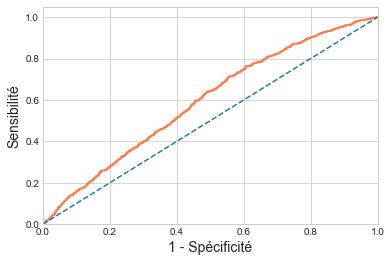

In [44]:
perf_Logistic2 = Performances(y_test, prediction_Logistic2[:, 1])

### SMOTE SE + GridSearch